# Paper Figure 3: Feature Finder

This notebook uses GPU, so please run in an environment with CUDA installed.


In [1]:
import os
from test_files import get_files, prepare_test

files = ['thermo_HeLa.raw']

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Thu_Jun_11_22:26:48_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.0, V11.0.194
Build cuda_11.0_bu.relgpu_drvr445TC445_37.28540450_0


In [3]:
tmp_folder = os.path.join(os.getcwd(),'temp/')
test_folder = 'fig3'

get_files(tmp_folder, files)
prepare_test(files, tmp_folder, test_folder)

Creating dir F:\alphapept\sandbox\temp/fig3.


## Convert raw file

In [4]:
import alphapept.settings
import alphapept.paths
import alphapept.interface

test_folder = os.path.join(tmp_folder, test_folder)

file_name = os.path.join(test_folder, files[0])
settings = alphapept.settings.load_settings(alphapept.paths.DEFAULT_SETTINGS_PATH)
settings['experiment']['file_paths'] = [file_name]
settings_ = alphapept.interface.import_raw_data(settings)
base, ext = os.path.splitext(file_name)

2021-06-07 18:43:29> Logging to C:\Users\admin\alphapept\logs\log_20210607184329.txt.
2021-06-07 18:43:29> Platform information:
2021-06-07 18:43:29> system     - Windows
2021-06-07 18:43:29> release    - 10
2021-06-07 18:43:29> version    - 10.0.18363
2021-06-07 18:43:29> machine    - AMD64
2021-06-07 18:43:29> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-06-07 18:43:29> cpu count  - 24
2021-06-07 18:43:29> ram memory - 106.9/127.7 Gb (available/total)
2021-06-07 18:43:29> 
2021-06-07 18:43:29> Python information:
2021-06-07 18:43:29> SQLAlchemy     - 1.3.22
2021-06-07 18:43:29> alphapept      - 0.3.26
2021-06-07 18:43:29> biopython      - 1.78
2021-06-07 18:43:29> click          - 7.1.2
2021-06-07 18:43:29> comtypes       - 1.1.7
2021-06-07 18:43:29> fastcore       - 1.3.5
2021-06-07 18:43:29> h5py           - 3.1.0
2021-06-07 18:43:29> lxml           - 4.6.2
2021-06-07 18:43:29> matplotlib     - 3.3.3
2021-06-07 18:43:29> nbdev          - 1.1.4
2021-06-07 18:

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-06-07 18:43:29> Processing 1 files for step raw_conversion
2021-06-07 18:43:29> File F:\alphapept\sandbox\temp/fig3\thermo_HeLa has extension .raw - converting from Thermo.
2021-06-07 18:45:40> File conversion complete. Extracted 120,226 precursors.
2021-06-07 18:45:42> File conversion of file F:\alphapept\sandbox\temp/fig3\thermo_HeLa.raw complete.


## Prepare settings for Feature Finder

In [5]:
import numpy as np

ms_file = alphapept.io.MS_Data_File(f"{base}.ms_data.hdf", is_read_only=True)
query_data = ms_file.read_DDA_query_data()
int_data = np.array(query_data['int_list_ms1'])

f_settings = settings['features']
max_gap = f_settings['max_gap']
centroid_tol = f_settings['centroid_tol']
hill_split_level = f_settings['hill_split_level']
hill_smoothing = f_settings['hill_smoothing']
hill_check_large = f_settings['hill_check_large']

iso_charge_min = f_settings['iso_charge_min']
iso_charge_max = f_settings['iso_charge_max']
iso_n_seeds = f_settings['iso_n_seeds']

hill_nboot_max = f_settings['hill_nboot_max']
hill_nboot = f_settings['hill_nboot']
iso_mass_range = f_settings['iso_mass_range']

iso_corr_min = f_settings['iso_corr_min']

In [6]:
import timeit
import time
import alphapept.performance
import alphapept.feature_finding
import importlib
import logging

def timing_decorator(func, timings_dict, repeats=3, loops_per_repeat=1):
    def wrapper(*args, **kwargs):
        if func.__name__ not in timings_dict:
            timings_dict[func.__name__] = {}
        if alphapept.performance.COMPILATION_MODE in timings_dict[func.__name__]:
            logging.warning(
                f"{func.__name__} is already timed for {alphapept.performance.COMPILATION_MODE}"
            )
        start = time.time()
        results = func(*args, **kwargs)
        timings_dict[func.__name__][alphapept.performance.COMPILATION_MODE] = time.time() - start
        return results
    return wrapper

2021-06-07 18:45:42> init


  0%|                                                                                            | 0/1 [02:14<?, ?it/s]


In [7]:
def time_feature_finding_functions(
    compilation_mode,
    timings_dict,
    repeats=3,
    loops_per_repeat=1
):
    print(f"Running feature finding functions with compilation mode '{compilation_mode}'")
    alphapept.performance.set_compilation_mode(compilation_mode)
    importlib.reload(alphapept.feature_finding)
    alphapept.feature_finding.connect_centroids_unidirection = timing_decorator(
        alphapept.feature_finding.connect_centroids_unidirection,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.convert_connections_to_array = timing_decorator(
        alphapept.feature_finding.convert_connections_to_array,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.eliminate_overarching_vertex = timing_decorator(
        alphapept.feature_finding.eliminate_overarching_vertex,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.path_finder = timing_decorator(
        alphapept.feature_finding.path_finder,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.find_path_start = timing_decorator(
        alphapept.feature_finding.find_path_start,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.find_path_length = timing_decorator(
        alphapept.feature_finding.find_path_length,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.fill_path_matrix = timing_decorator(
        alphapept.feature_finding.fill_path_matrix,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
        
    logging.info(f'Hill extraction with centroid_tol {centroid_tol} and max_gap {max_gap}')
    hill_ptrs, hill_data, path_node_cnt, score_median, score_std = alphapept.feature_finding.extract_hills(query_data, max_gap, centroid_tol)
    logging.info(f'Number of hills {len(hill_ptrs):,}, len = {np.mean(path_node_cnt):.2f}')

In [8]:
timings_dict = {}

modes = ["cuda", "numba-multithread", "numba", "python"]

for mode in modes:
    time_feature_finding_functions(mode, timings_dict)


Running feature finding functions with compilation mode 'cuda'
2021-06-07 18:45:45> Hill extraction with centroid_tol 8 and max_gap 2
2021-06-07 18:45:48> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'numba-multithread'
2021-06-07 18:45:48> Hill extraction with centroid_tol 8 and max_gap 2
2021-06-07 18:45:56> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'numba'
2021-06-07 18:45:56> Hill extraction with centroid_tol 8 and max_gap 2
2021-06-07 18:46:05> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'python'
2021-06-07 18:46:05> Hill extraction with centroid_tol 8 and max_gap 2
2021-06-07 18:51:32> Number of hills 1,105,353, len = 17.35


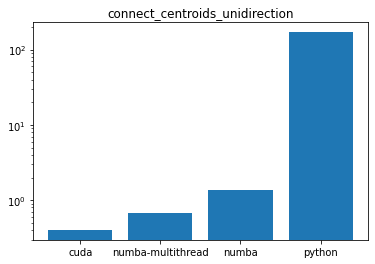

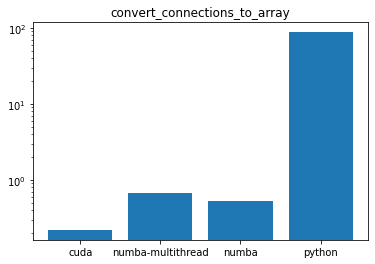

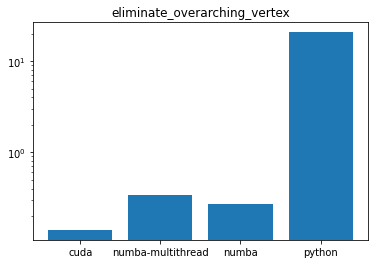

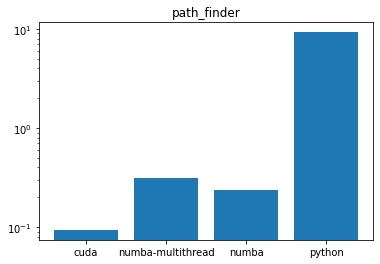

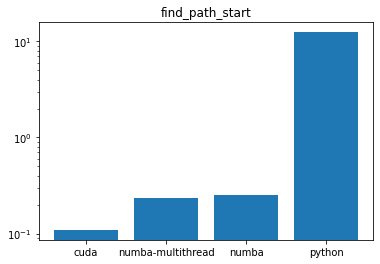

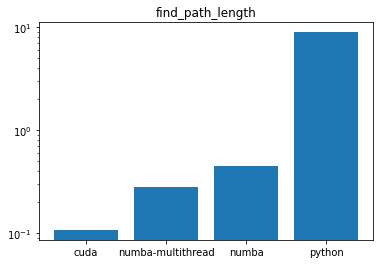

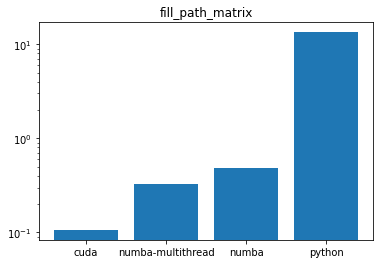

In [9]:
from matplotlib import pyplot as plt
include_python = True
for func in timings_dict:
    if not include_python:
        plt.bar(list(timings_dict[func].keys())[:-1], list(timings_dict[func].values())[:-1])
    else:
        plt.bar(list(timings_dict[func].keys()), list(timings_dict[func].values()))
    plt.yscale('log')
    plt.title(func)
    plt.show()

## Get summary timing

In [34]:
timings_dict = {'connect_centroids_unidirection': {'cuda': 0.4028615951538086,
  'numba-multithread': 0.6658666133880615,
  'numba': 1.3539395332336426,
  'python': 169.8435094356537},
 'convert_connections_to_array': {'cuda': 0.21874642372131348,
  'numba-multithread': 0.66977858543396,
  'numba': 0.5295760631561279,
  'python': 87.82068657875061},
 'eliminate_overarching_vertex': {'cuda': 0.14067292213439941,
  'numba-multithread': 0.3437490463256836,
  'numba': 0.26830434799194336,
  'python': 20.700212240219116},
 'path_finder': {'cuda': 0.09373021125793457,
  'numba-multithread': 0.312467098236084,
  'numba': 0.23467350006103516,
  'python': 9.26594591140747},
 'find_path_start': {'cuda': 0.10939526557922363,
  'numba-multithread': 0.23545408248901367,
  'numba': 0.24992799758911133,
  'python': 12.421699523925781},
 'find_path_length': {'cuda': 0.10823464393615723,
  'numba-multithread': 0.28179931640625,
  'numba': 0.454831600189209,
  'python': 8.966736078262329},
 'fill_path_matrix': {'cuda': 0.10622358322143555,
  'numba-multithread': 0.32889819145202637,
  'numba': 0.4879722595214844,
  'python': 13.420031070709229}}

<ipython-input-32-f3f9cd904793>:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 1500])


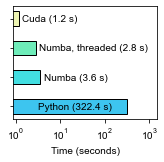

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dark_blue = '#17212b'
light_blue = '#3dc5ef'
teal= '#42dee1'
green = '#6eecb9'
yellow = '#eef5b3'

colors = [light_blue, teal, green, yellow]
data = pd.DataFrame.from_dict(timings_dict).sum(axis=1).iloc[::-1]

hfont = {'fontname':'Arial', 'size':10}
plt.figure(figsize=(2.363,2.363)) #60x60

height=0.5

text = [f'Python ({data.python:.1f} s)', f"Numba ({data.numba:.1f} s)", f"Numba, threaded ({data['numba-multithread']:.1f} s)", f"Cuda ({data.cuda:.1f} s)"]


for i in range(len(data)): 
    t = data[i]
    plt.barh(i, t, height, color = colors[i], linewidth=1, edgecolor='black')
    if i == 0:
        plt.text(t/100, i, text[i], **hfont, va='center')
    else:
        plt.text(t*1.2, i, text[i], **hfont, va='center')
        
plt.yticks(range(len(data)), data.index, **hfont)
plt.xticks(**hfont)

plt.xscale('log')
plt.xlim([0, 1500])
plt.xlabel('Time (seconds)', **hfont)
ax = plt.gca()
ax.set_yticklabels([])
plt.tight_layout()
plt.xticks([1e0, 1e1, 1e2 , 1e3])

plt.savefig('p_03_ff.pdf')  
plt.show()